# Cat Boost for default prediction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gaarutyunov/credit-risk/blob/master/notebooks/colab_cat_boost.ipynb)

## Environment settings

For better performance change Colab runtime type to GPU

In [1]:
!git clone https://github.com/gaarutyunov/credit-risk.git

Cloning into 'credit-risk'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 406 (delta 38), reused 54 (delta 23), pack-reused 334
Receiving objects: 100% (406/406), 3.44 MiB | 28.88 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [2]:
%cd credit-risk

/content/credit-risk


In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/sberbank-ai/wing.git (to revision master) to /tmp/pip-install-dlrk1q7a/wing_ec1f2c5e162a47b5b50101bd98169ed2
  Running command git clone -q https://github.com/sberbank-ai/wing.git /tmp/pip-install-dlrk1q7a/wing_ec1f2c5e162a47b5b50101bd98169ed2
     |████████████████████████████████| 151 kB 13.2 MB/s 
     |████████████████████████████████| 79 kB 4.4 MB/s 
     |████████████████████████████████| 76.6 MB 73 kB/s 
     |████████████████████████████████| 117 kB 54.4 MB/s 
     |████████████████████████████████| 596 kB 16.2 MB/s 
  Created wheel for wing: filename=wing-0.1.6-py3-none-any.whl size=12768 sha256=18283bd5f936b5d05d087cd25b6990585396337784b64aad38cf751e8bc4ef4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6_10tuz4/wheels/d0/d3/78/d1cb5717341968f8319fa57765f68a894fc1b21d4f4068b519
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_r

To get username and key follow instructions in [readme](https://github.com/Kaggle/kaggle-api)

In [ ]:
%env KAGGLE_USERNAME=<username>
%env KAGGLE_KEY=<key>

In [5]:
!kaggle datasets download wordsforthewise/lending-club

 98% 1.24G/1.26G [00:05<00:00, 209MB/s]
100% 1.26G/1.26G [00:05<00:00, 261MB/s]


In [6]:
!unzip lending-club.zip

Archive:  lending-club.zip
  inflating: accepted_2007_to_2018Q4.csv.gz  
  inflating: accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: rejected_2007_to_2018Q4.csv.gz  
  inflating: rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


In [7]:
!mkdir data

In [8]:
!mv accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv data/accepted_2007_to_2018Q4.csv
!mv rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv data/rejected_2007_to_2018Q4.csv

## Preprocessing

In [9]:
from pipeline import get_pipeline

preprocessing = get_pipeline(
    name="cat_boost",
    group='preprocessing',
    debug=True,
)

_target_: pipeline.LabelInferPipeline
memory: ./cache/preprocessing/cat_boost
steps:
- - CSVReader
  - _target_: pipeline.CSVReader
    _convert_: all
    file: data/accepted_2007_to_2018Q4.csv
    columns:
    - term
    - emp_length
    - home_ownership
    - verification_status
    - purpose
    - zip_code
    - addr_state
    - earliest_cr_line
    - application_type
    - verification_status_joint
    - sec_app_earliest_cr_line
    - disbursement_method
    - loan_amnt
    - fico_range_low
    - fico_range_high
    - revol_bal
    - emp_title
    - loan_status
- - LabelTransformer
  - _target_: pipeline.LabelTransformer
    _convert_: all
- - EmpTitle
  - _target_: pipeline.JobTransformer
    _convert_: all
    max_jobs: 20
- - ImputeNumerical
  - _target_: pipeline.ApplyToColumns
    _convert_: all
    inner:
      _target_: sklearn.impute.SimpleImputer
      strategy: mean
    columns:
    - loan_amnt
    - fico_range_low
    - fico_range_high
    - revol_bal
- - ImputeCategoric

In [10]:
X = preprocessing.fit_transform([], y=[])
y = preprocessing.label_transformer.label

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 51.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:355: UserWarning: Persisting input arguments took 52.45s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, shuffle=True
)

## Training

To train with CPU remove overrides

In [12]:
from pipeline import get_pipeline

classifier = get_pipeline(
    name="cat_boost",
    group='classifier',
    overrides=["+classifier_pipeline.steps.0.1.task_type=GPU"],
    debug=True,
)

_target_: sklearn.pipeline.Pipeline
memory: ./cache/classifier/cat_boost
steps:
- - Classifier
  - _target_: catboost.CatBoostClassifier
    _convert_: all
    iterations: 500
    learning_rate: 0.01
    cat_features:
    - term
    - emp_length
    - emp_title
    - home_ownership
    - verification_status
    - purpose
    - zip_code
    - addr_state
    - earliest_cr_line
    - application_type
    - verification_status_joint
    - sec_app_earliest_cr_line
    - disbursement_method
    task_type: GPU



In [13]:
classifier.fit(X_train, y_train)

0:	learn: 0.6881192	total: 160ms	remaining: 1m 19s
1:	learn: 0.6832210	total: 303ms	remaining: 1m 15s
2:	learn: 0.6784056	total: 437ms	remaining: 1m 12s
3:	learn: 0.6737492	total: 561ms	remaining: 1m 9s
4:	learn: 0.6692096	total: 689ms	remaining: 1m 8s
5:	learn: 0.6647525	total: 820ms	remaining: 1m 7s
6:	learn: 0.6603708	total: 953ms	remaining: 1m 7s
7:	learn: 0.6561160	total: 1.09s	remaining: 1m 6s
8:	learn: 0.6519210	total: 1.23s	remaining: 1m 6s
9:	learn: 0.6478165	total: 1.36s	remaining: 1m 6s
10:	learn: 0.6438222	total: 1.49s	remaining: 1m 6s
11:	learn: 0.6399670	total: 1.62s	remaining: 1m 5s
12:	learn: 0.6361929	total: 1.74s	remaining: 1m 5s
13:	learn: 0.6324647	total: 1.87s	remaining: 1m 5s
14:	learn: 0.6288491	total: 1.99s	remaining: 1m 4s
15:	learn: 0.6253334	total: 2.12s	remaining: 1m 4s
16:	learn: 0.6218837	total: 2.27s	remaining: 1m 4s
17:	learn: 0.6184892	total: 2.39s	remaining: 1m 4s
18:	learn: 0.6152109	total: 2.52s	remaining: 1m 3s
19:	learn: 0.6119885	total: 2.65s	rema

Pipeline(memory='./cache/classifier/cat_boost',
         steps=[['Classifier', <catboost.core.CatBoostClassifier object at 0x7f8e54611810>]])

In [16]:
y_pred = classifier.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8003992150568814

In [18]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.5044118867933927

In [19]:
from sklearn.metrics import average_precision_score

average_precision_score(y_test, y_pred)

0.2042559010457584

In [20]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.02120787910186175

In [23]:
y_pred = classifier.predict_proba(X_test)[:, 1]

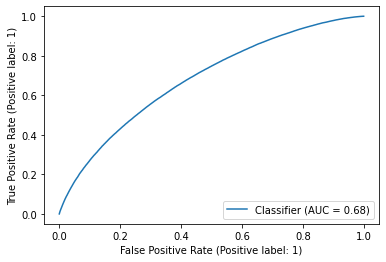

In [24]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_pred)

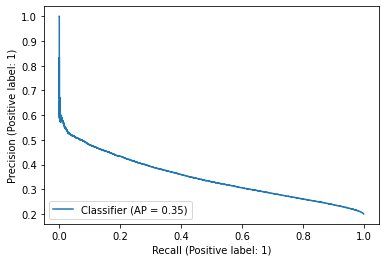

In [25]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test, y_pred)

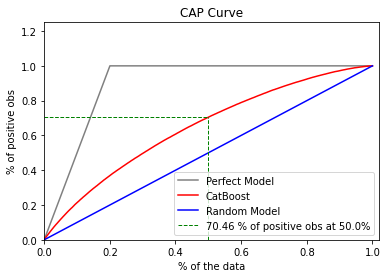

In [26]:
from utils import capcurve

capcurve(y_test, y_pred)

In [27]:
classifier.steps[0][1].save_model("models/cat_boost")